In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from scipy.stats import skew

pd.options.display.max_columns = 500

Снова потренируемся в предсказании цен на недвижимость из [очередного датасета с каггла](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/)! В качестве основной метрики для валидации моделей будем использовать, как и ранее, `MSLE`.

P.S. в данной домашней работе при построении любых моделей, использующих недетерменированные элементы (как бутстрап), в алгоритме указывайте параметр `random_state = 1` для воспроизводимости результатов.

In [2]:
df = (
    pd.read_csv('C:/Users/maslo/Desktop/karpov_start_ml/2_module/19_lesson/materials/train_houses_reg.csv')
    .drop('Id', axis=1)
)

df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,

In [3]:
### Разделим выборку на объекты-таргеты

y = df['SalePrice']
X = df.drop(columns=['SalePrice'])

### Логарифмируем таргет для будущей оптимизации
### MSLE через MSE

log_target = np.log1p(y)

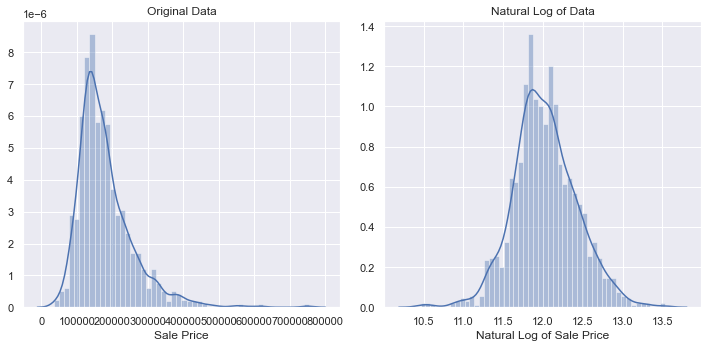

In [4]:
### Это позволяет получить нормальное распределение таргета
### Важно, например, для построения корректной
### С точки зрения статистических свойств
### Линейной модели.
### Хотя здесь мы будем строить ансамбли деревьев, 
### И это не особо интересно.

sns.set(rc={'figure.figsize':(15,10)})

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(y, bins=50)
plt.title('Original Data')
plt.xlabel('Sale Price')

plt.subplot(1,2,2)
sns.distplot(log_target, bins=50)
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of Sale Price')
plt.tight_layout()

### В начале поработаем с пропусками!

Если в какой-либо колонке оказывается достаточно много пропусков, обычно советуют от них избавляться. Мотивировано это тем, что в таких фичах мы можем наблюдать серьезный недостаток информативности, а заполнение пропусков может лишь внести лишнего шума в данные.

Избавьтесь от всех колонок, в которых пропусков оказывается больше 15%. (1б)

In [5]:
nans = pd.DataFrame(X.isna().mean(), columns=['nan_pct'])
drop_cols = list(nans[nans['nan_pct'] > 0.15].index)

In [6]:
X = X.drop(drop_cols, axis=1)

In [7]:
len(X.columns)

73

Вещественные колонки заполните медианным значением по фиче, а категориальные - самой популярной по колонке категорией. (2б)

Заметьте, что колонки `MoSold`, `YrSold`, `GarageYrBlt`, `YearBuilt`, `YearRemodAdd` хоть в таблице не являются типами `object`, вряд ли их справедливо использовать как вещественные. Обработайте их как категориальные.

In [8]:
for col in ['MoSold', 'YrSold', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd']:
    X[col] = X[col].astype('object')

In [9]:
X.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [10]:
number_cols = X.select_dtypes(['int64', 'float64']).columns

In [11]:
for col in number_cols:
    X[col] = X[col].fillna(X[col].median())

In [12]:
cat_cols = X.select_dtypes('object').columns

In [13]:
X['MoSold'].value_counts().head(1).index[0]

6

In [14]:
for col in cat_cols:
    X[col] = X[col].fillna(X[col].value_counts().head(1).index[0])

In [15]:
X.to_csv('C:/Users/maslo/Desktop/karpov_start_ml/2_module/19_lesson/materials/res.csv', index=False)

In [16]:
### Отложенная выборка

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    log_target, 
                                                    test_size=0.25, 
                                                    random_state=1)

Напишите трансформер, который будет делать следующее:

1. Масштабирование через StandardScaler для вещественных колонок
2. Кодирование через OneHotEncoder для категориальных, содержащих менее, чем 5 уникальных значений
3. Кодирование через TargetEncoder для всех остальных категориальных

Для этого советуем воспользоваться библиотекой `category_encoders` помимо `sklearn`.

А так же классом `ColumnTransformer` из `sklearn.compose`.

P.S. Напомним, что для деревьев процедура StandardScaling не обязательна (решающие деревья нечувствительны к масштабу). Тем не менее, это может сделать обучение модели менее тяжелым (хранить большие числа сложно для задач с большим количеством данных).

In [19]:
X_train.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [21]:
number_columns = list(X_train.select_dtypes(['int64', 'float64']).columns)

In [26]:
cat_cols = pd.DataFrame(X_train.select_dtypes('object').nunique(), columns=['unique'])

In [30]:
cat_cols_one_hot = list(cat_cols[cat_cols['unique'] < 5].index)

In [31]:
cat_cols_mte = list(cat_cols[cat_cols['unique'] >= 5].index)

In [32]:
number_columns_ix = [list(X_train.columns).index(col) for col in number_columns]

In [33]:
cat_cols_one_hot_ix = [list(X_train.columns).index(col) for col in cat_cols_one_hot]

In [34]:
cat_cols_mte_ix = [list(X_train.columns).index(col) for col in cat_cols_mte]

In [39]:
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import StandardScaler

t = [
    ('OneHotEncoder', OneHotEncoder(), cat_cols_one_hot_ix),
    ('MeanTargetEncoder', TargetEncoder(), cat_cols_mte_ix),
    ('StandardScaler', StandardScaler(), number_columns_ix)
]

col_transform = ColumnTransformer(transformers=t)

In [40]:
col_transform.fit(X_train, y_train)

ColumnTransformer(transformers=[('OneHotEncoder', OneHotEncoder(),
                                 [3, 4, 5, 6, 8, 22, 24, 27, 28, 29, 37, 38, 50,
                                  56, 61]),
                                ('MeanTargetEncoder', TargetEncoder(),
                                 [1, 7, 9, 10, 11, 12, 13, 18, 19, 20, 21, 25,
                                  26, 30, 32, 36, 39, 52, 54, 59, 60, 71, 72]),
                                ('StandardScaler', StandardScaler(),
                                 [0, 2, 14, 15, 16, 17, 23, 31, 33, 34, 35, 40,
                                  41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 53,
                                  55, 57, 58, 62, 63, 64, 65, ...])])

Посмотрите, как на наших данных справляется одно Решающее Дерево с дефолтными гиперпараметрами. Добавьте написанный ранее трансформер в модель. (1б)

In [43]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('column_transformer', col_transform),
    ('decision_tree', DecisionTreeRegressor())
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [3, 4, 5, 6, 8, 22, 24, 27,
                                                   28, 29, 37, 38, 50, 56,
                                                   61]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [1, 7, 9, 10, 11, 12, 13, 18,
                                                   19, 20, 21, 25, 26, 30, 32,
                                                   36, 39, 52, 54, 59, 60, 71,
                                                   72]),
                                                 ('StandardScaler',
                                                  StandardScaler(),
                                                

In [45]:
np.mean((y_test - pipe.predict(X_test))**2)

0.04328050593532509

Справляется даже без контроля переобучения!

Посмотрим на перформанс Случайного Леса! Подберите параметры по отложенной выборке по данной сетке `param_grid`. Помните, что подбирать количество деревьев не супер обязательно, достаточно поставить их побольше. Что произошло с качеством модели по сравнению с одиноким деревом? (2б)

In [46]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    "random_forest__max_depth": [10, 15, 20],
    "random_forest__min_samples_split": [2, 5, 10],
    "random_forest__min_samples_leaf": [1, 3, 5]
}

pipe = Pipeline([
    ('column_transformer', col_transform),
    ('random_forest', RandomForestRegressor())
])

search = GridSearchCV(pipe,
                      param_grid,
                      scoring='neg_mean_squared_error')

search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(transformers=[('OneHotEncoder',
                                                                         OneHotEncoder(),
                                                                         [3, 4,
                                                                          5, 6,
                                                                          8, 22,
                                                                          24,
                                                                          27,
                                                                          28,
                                                                          29,
                                                                          37,
                                                                          38,
                                                 

In [47]:
search.best_params_

{'random_forest__max_depth': 20,
 'random_forest__min_samples_leaf': 1,
 'random_forest__min_samples_split': 2}

In [57]:
pipe = Pipeline([
    ('column_transformer', col_transform),
    ('random_forest', RandomForestRegressor(max_depth=20, min_samples_leaf=1, min_samples_split=2))
])

In [58]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [3, 4, 5, 6, 8, 22, 24, 27,
                                                   28, 29, 37, 38, 50, 56,
                                                   61]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [1, 7, 9, 10, 11, 12, 13, 18,
                                                   19, 20, 21, 25, 26, 30, 32,
                                                   36, 39, 52, 54, 59, 60, 71,
                                                   72]),
                                                 ('StandardScaler',
                                                  StandardScaler(),
                                                

In [51]:
np.mean((y_test - pipe.predict(X_test))**2)

0.017796621354562375

In [59]:
np.mean((y_train - pipe.predict(X_train))**2)

0.003006457939716154

Попробуем теперь поэкспериментировать с бэггингами. 

Постройте бэггинги с 100 базовыми моделями (и остальными стандартными параметрами) над линейной регрессией, деревом и случайным лесом (бэггинг над бэггингом!). 

Какое качество у каждой модели на тесте?

Какой алгоритм получился лучше с точки зрения качества на тесте? (2б)

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor

pipe = Pipeline([
    ('column_transformer', col_transform),
    ('regression', LinearRegression())
])

bagging = BaggingRegressor(base_estimator=pipe,
                          n_estimators=100,
                          random_state=32)

bagging.fit(X_train, y_train)
np.mean((y_test - bagging.predict(X_test))**2)

8.144859112810659e+17

In [54]:
pipe = Pipeline([
    ('column_transformer', col_transform),
    ('regression', DecisionTreeRegressor())
])

bagging = BaggingRegressor(base_estimator=pipe,
                          n_estimators=100,
                          random_state=32)

bagging.fit(X_train, y_train)
np.mean((y_test - bagging.predict(X_test))**2)

0.018279938246814367

In [55]:
pipe = Pipeline([
    ('column_transformer', col_transform),
    ('regression', RandomForestRegressor())
])

bagging = BaggingRegressor(base_estimator=pipe,
                          n_estimators=100,
                          random_state=32)

bagging.fit(X_train, y_train)
np.mean((y_test - bagging.predict(X_test))**2)

0.01822299350477333

In [56]:
np.mean((y_train - bagging.predict(X_train))**2)

0.005870432348934771

Улучшил ли бэггинг над Лесом качество по сравнению с одним Лесом с точки зрения как качества на тесте, так и на трейне. Как это можно объяснить? Как думаете, много ли смысла в использовании бэггинга над линейными моделями? Выбрали бы вы в данной ситуации именно их в качестве базовых?

### Добавим новые фичи!

Создайте следующие четыре новые вещественные фичи:

1. Отношения площади 1 этажа к общей площади (колонки 1stFlrSF и GrLivArea, в %)
2. Отношение Площади завершенного фундамента первого типа к общей площади фундамента (колонки BsmtFinSF1 и TotalBsmtSF, в %)
3. Возраст дома (между YearBuilt и YrSold)
4. Общая площадь самого дома и фундамента/цоколя (1stFlrSF + 2ndFlrSF + TotalBsmtSF)

Обучите заново Случайный лес и найдите лучшие гиперпараметры на старой сетке.

Улучшили ли качество модели новые фичи? (4б)

In [61]:
X_train['1stFlrSF_div_GrLivArea'] = X_train['1stFlrSF'] * 100 / X_train['GrLivArea']
X_train['BsmtFinSF1_div_TotalBsmtSF'] = X_train['BsmtFinSF1'] * 100 / X_train['TotalBsmtSF']
X_train['YrSold_diff_YearBuilt'] = X_train['YrSold'] - X_train['YearBuilt']
X_train['1stFlrSF_2ndFlrSF_TotalBsmtSF'] = X_train['1stFlrSF'] + X_train['2ndFlrSF'] + X_train['TotalBsmtSF']

In [62]:
X_test['1stFlrSF_div_GrLivArea'] = X_test['1stFlrSF'] * 100 / X_test['GrLivArea']
X_test['BsmtFinSF1_div_TotalBsmtSF'] = X_test['BsmtFinSF1'] * 100 / X_test['TotalBsmtSF']
X_test['YrSold_diff_YearBuilt'] = X_test['YrSold'] - X_test['YearBuilt']
X_test['1stFlrSF_2ndFlrSF_TotalBsmtSF'] = X_test['1stFlrSF'] + X_test['2ndFlrSF'] + X_test['TotalBsmtSF']

In [63]:
param_grid = {
    "random_forest__max_depth": [10, 15, 20],
    "random_forest__min_samples_split": [2, 5, 10],
    "random_forest__min_samples_leaf": [1, 3, 5]
}

pipe = Pipeline([
    ('column_transformer', col_transform),
    ('random_forest', RandomForestRegressor())
])

search = GridSearchCV(pipe,
                      param_grid,
                      scoring='neg_mean_squared_error')

search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(transformers=[('OneHotEncoder',
                                                                         OneHotEncoder(),
                                                                         [3, 4,
                                                                          5, 6,
                                                                          8, 22,
                                                                          24,
                                                                          27,
                                                                          28,
                                                                          29,
                                                                          37,
                                                                          38,
                                                 

In [64]:
search.best_params_

{'random_forest__max_depth': 15,
 'random_forest__min_samples_leaf': 1,
 'random_forest__min_samples_split': 2}

In [65]:
pipe = Pipeline([
    ('column_transformer', col_transform),
    ('random_forest', RandomForestRegressor(max_depth=15, min_samples_leaf=1, min_samples_split=2))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [3, 4, 5, 6, 8, 22, 24, 27,
                                                   28, 29, 37, 38, 50, 56,
                                                   61]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [1, 7, 9, 10, 11, 12, 13, 18,
                                                   19, 20, 21, 25, 26, 30, 32,
                                                   36, 39, 52, 54, 59, 60, 71,
                                                   72]),
                                                 ('StandardScaler',
                                                  StandardScaler(),
                                                

In [66]:
np.mean((y_test - pipe.predict(X_test))**2)

0.017804748639686733

In [67]:
np.mean((y_train - pipe.predict(X_train))**2)

0.003052165006780696